# Multi-View DenseNet121 Training

This notebook demonstrates the training of a Multi-View DenseNet121 model for mammogram classification.

The notebook is organized as follows:
1. Setup and Imports
2. Configuration and Data Paths
3. Data Loading and Preprocessing
4. Model Creation and Training Setup
5. Training Loop
6. Memory Management

In [1]:
## Required Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import v2 as transforms
from torch.utils.data import DataLoader
import time
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
## Import Model and Dataset
from MakeDataset_VinDr_classification import MakeDataset_VinDr_classification
from models.densenet121 import create_model  # Imports from models/densenet121.py

In [3]:
## Devices
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Available GPUs: ", torch.cuda.device_count())
print("Current device ID: ", torch.cuda.current_device())

Available GPUs:  1
Current device ID:  0


In [4]:
## Configuration
extension = ".png"
target_size = 384  # DenseNet can work with different input sizes
batch_size = 8
learning_rate = 1e-4
epochs = 5
threshold = 0.5
weight_decay = 1e-3

In [5]:
## Data Paths
image_dir = "Dataset/"
label_dir_csv = "Dataset/remaining_full_path.csv"

In [6]:
## Data Loaders
from torch.utils.data import Subset, DataLoader
import numpy as np
from collections import Counter
# Define transforms - DenseNet expects normalized inputs
transform = transforms.Compose([
    transforms.Resize((target_size, target_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Create the full dataset
full = MakeDataset_VinDr_classification(
    image_dir=image_dir,
    label_csv=label_dir_csv,
    transform=transform,
    mode='train',  # mode doesn't matter here since we're splitting manually
    split_size=0.0,  # No need for internal splitting
    target_size=target_size
)

# Get total size and create permuted indices
total = len(full)
indices = np.random.RandomState(42).permutation(total)

# Calculate split sizes (70% train, 15% val, 15% test)
train_size = int(0.7 * total)
val_size = int(0.15 * total)
test_size = total - train_size - val_size  # Use remaining to avoid rounding issues

# Split indices for each set
train_idx = indices[:train_size]
val_idx = indices[train_size:train_size + val_size]
test_idx = indices[train_size + val_size:]

# Create subsets
train_subset = Subset(full, train_idx)
val_subset = Subset(full, val_idx)
test_subset = Subset(full, test_idx)

# Create data loaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
def get_label_distribution(subset, name="Subset"):
    labels = [subset.dataset.samples[i][2] for i in subset.indices]
    counter = Counter(labels)
    total = sum(counter.values())
    print(f"\n{name} Class Distribution:")
    for cls, count in counter.items():
        label_name = f"Class {cls} ({'Negative' if cls == 0 else 'Positive'})"
        print(f"{label_name}: {count} samples ({(count / total) * 100:.2f}%)")
    print(f"Total samples: {total}")

# Print class distributions
get_label_distribution(train_subset, "Train")
get_label_distribution(val_subset, "Validation")
get_label_distribution(test_subset, "Test")
# Print split sizes to verify
print(f"Total dataset size: {total}")
print(f"Training set size: {len(train_subset)} ({len(train_subset)/total:.1%})")
print(f"Validation set size: {len(val_subset)} ({len(val_subset)/total:.1%})")
print(f"Test set size: {len(test_subset)} ({len(test_subset)/total:.1%})")


/home/intern04/miniconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(



View distribution:
view_position
MLO    9773
CC     9693
Name: count, dtype: int64

Laterality distribution:
laterality
L    9741
R    9725
Name: count, dtype: int64
Initial count: 19466
After dropping NA: 19466
Unique study_ids: 4750
Final paired samples: 9499

Train Class Distribution:
Class 0 (Negative): 4459 samples (67.06%)
Class 1 (Positive): 2190 samples (32.94%)
Total samples: 6649

Validation Class Distribution:
Class 0 (Negative): 975 samples (68.47%)
Class 1 (Positive): 449 samples (31.53%)
Total samples: 1424

Test Class Distribution:
Class 0 (Negative): 940 samples (65.92%)
Class 1 (Positive): 486 samples (34.08%)
Total samples: 1426
Total dataset size: 9499
Training set size: 6649 (70.0%)
Validation set size: 1424 (15.0%)
Test set size: 1426 (15.0%)


In [7]:
## Create and Configure Model
model = create_model(num_classes=1, pretrained=True, drop_rate=0.2).to(device)

# Print model parameters
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters: ", pytorch_total_params // 10 ** 6, " mil")
print("Total number of trainable parameters: ", pytorch_total_trainable_params // 10 ** 6, " mil")

/home/intern04/miniconda3/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intern04/miniconda3/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total number of parameters:  16  mil
Total number of trainable parameters:  16  mil


In [8]:
## Training Utilities
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

# Initialize optimizer, loss function, and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20)
criterion = nn.BCELoss()
early_stopper = EarlyStopper(patience=75, min_delta=0)
curr_best_val_acc = 0.0

In [9]:
## Training Loop
for epoch in range(1, epochs + 1):
    since = time.time()
    print('-' * 10)
    model.train()  # Set the model to training mode
    running_loss = 0.0
    print("#########Epoch: ", epoch)
    total = 0
    correct = 0
    
    # For computing metrics
    all_labels = []
    all_predictions = []

    # Training phase
    for i, data in enumerate(train_loader):
        inputs_cc, inputs_mlo, labels = data
        inputs_cc, inputs_mlo, labels = inputs_cc.float().to(device), inputs_mlo.float().to(device), labels.float().to(device)

        labels = labels.unsqueeze(1)
        predicted = model(inputs_cc, inputs_mlo)
        
        total_loss = criterion(predicted, labels)
        thresholded_preds = (predicted > threshold).float()
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
      
        running_loss += total_loss.item()
        total += labels.size(0)
        correct += (thresholded_preds == labels).sum().item()
        
        # Store predictions and labels for metrics computation
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(thresholded_preds.cpu().numpy())

    # Compute training metrics
    running_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_precision = precision_score(all_labels, all_predictions)
    train_recall = recall_score(all_labels, all_predictions)
    train_f1 = f1_score(all_labels, all_predictions)
    
    time_elapsed = time.time() - since
    curr_lr = optimizer.param_groups[0]["lr"]
    
    print(f"Epoch {epoch}")
    print(f"Training Metrics:")
    print(f"  Loss: {running_loss:.5f}")
    print(f"  Accuracy: {train_acc:.3f}%")
    print(f"  Precision: {train_precision:.3f}")
    print(f"  Recall: {train_recall:.3f}")
    print(f"  F1 Score: {train_f1:.3f}")
    print(f'  Time: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'  Learning rate: {curr_lr}')

    # Validation phase
    model.eval()
    total = 0
    correct = 0
    running_val_loss = 0.0
    
    # For computing validation metrics
    val_labels = []
    val_predictions = []

    with torch.no_grad():
        for data in val_loader:
            inputs_cc, inputs_mlo, labels = data
            inputs_cc, inputs_mlo, labels = inputs_cc.float().to(device), inputs_mlo.float().to(device), labels.float().to(device)
            
            labels = labels.unsqueeze(1)
            predicted = model(inputs_cc, inputs_mlo)
            
            total_loss = criterion(predicted, labels)
            thresholded_preds = (predicted > threshold).float()
            
            running_val_loss += total_loss.item()
            total += labels.size(0)
            correct += (thresholded_preds == labels).sum().item()
            
            # Store predictions and labels for metrics computation
            val_labels.extend(labels.cpu().numpy())
            val_predictions.extend(thresholded_preds.cpu().numpy())
    
    # Calculate validation metrics
    val_acc = 100 * correct / total
    running_val_loss = running_val_loss / len(val_loader)
    val_precision = precision_score(val_labels, val_predictions)
    val_recall = recall_score(val_labels, val_predictions)
    val_f1 = f1_score(val_labels, val_predictions)
    
    print("\nValidation Metrics:")
    print(f"  Loss: {running_val_loss:.5f}")
    print(f"  Accuracy: {val_acc:.3f}%")
    print(f"  Precision: {val_precision:.3f}")
    print(f"  Recall: {val_recall:.3f}")
    print(f"  F1 Score: {val_f1:.3f}")
    
    # Update scheduler and check early stopping
    scheduler.step(running_val_loss)
    if early_stopper.early_stop(running_val_loss):
        print("Early stopping triggered")
        break 
    


----------
#########Epoch:  1
Epoch 1
Training Metrics:
  Loss: 0.58298
  Accuracy: 71.755%
  Precision: 0.712
  Recall: 0.239
  F1 Score: 0.358
  Time: 5m 19s
  Learning rate: 0.0001

Validation Metrics:
  Loss: 0.57431
  Accuracy: 78.652%
  Precision: 0.884
  Recall: 0.372
  F1 Score: 0.524
----------
#########Epoch:  2
Epoch 2
Training Metrics:
  Loss: 0.53005
  Accuracy: 75.861%
  Precision: 0.769
  Recall: 0.382
  F1 Score: 0.511
  Time: 5m 22s
  Learning rate: 0.0001

Validation Metrics:
  Loss: 0.48713
  Accuracy: 78.511%
  Precision: 0.785
  Recall: 0.439
  F1 Score: 0.563
----------
#########Epoch:  3
Epoch 3
Training Metrics:
  Loss: 0.51026
  Accuracy: 76.342%
  Precision: 0.765
  Recall: 0.406
  F1 Score: 0.531
  Time: 5m 20s
  Learning rate: 0.0001

Validation Metrics:
  Loss: 0.55303
  Accuracy: 79.705%
  Precision: 0.864
  Recall: 0.423
  F1 Score: 0.568
----------
#########Epoch:  4
Epoch 4
Training Metrics:
  Loss: 0.49778
  Accuracy: 77.997%
  Precision: 0.787
  Recal

In [10]:
# Save model
torch.save(model.state_dict(), "densenet121_weights.pt")

import torch
import torchvision.models as models

"""# Recreate model architecture
model = models.densenet121(pretrained=False)
model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)

# Load weights
model.load_state_dict(torch.load("densenet121_weights.pt"))"""

'# Recreate model architecture\nmodel = models.densenet121(pretrained=False)\nmodel.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)\n\n# Load weights\nmodel.load_state_dict(torch.load("densenet121_weights.pt"))'

In [11]:
## Cleanup Memory
import gc
torch.cuda.empty_cache()  # Clear the GPU cache
gc.collect()  # Run Python garbage collector

# Print memory statistics
print("GPU Memory Summary after cleanup:")
print(torch.cuda.memory_summary())

GPU Memory Summary after cleanup:
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 301023 KiB |   6166 MiB |  79209 GiB |  79208 GiB |
|       from large pool |  94976 KiB |   5929 MiB |  77489 GiB |  77489 GiB |
|       from small pool | 206047 KiB |    283 MiB |   1719 GiB |   1719 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 301023 KiB |   6166 MiB |  79209 GiB |  79208 GiB |
|       from large pool |  949

Evaluating model on test set...

Test Set Metrics:
  Loss: 0.50847
  Accuracy: 78.261%
  Precision: 0.893
  Recall: 0.412
  F1 Score: 0.563


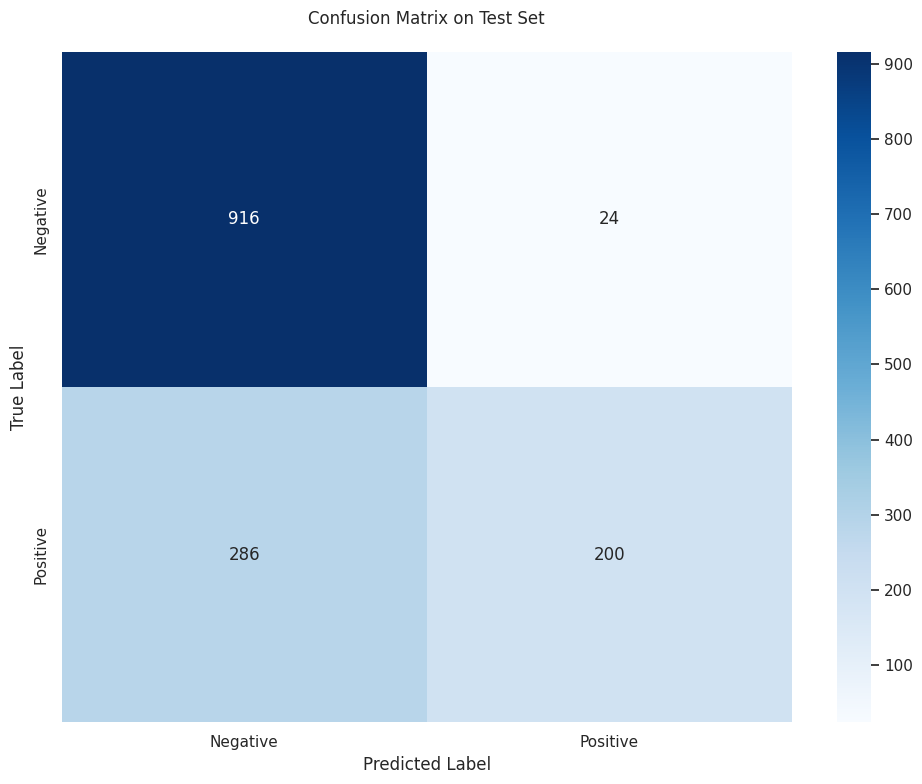

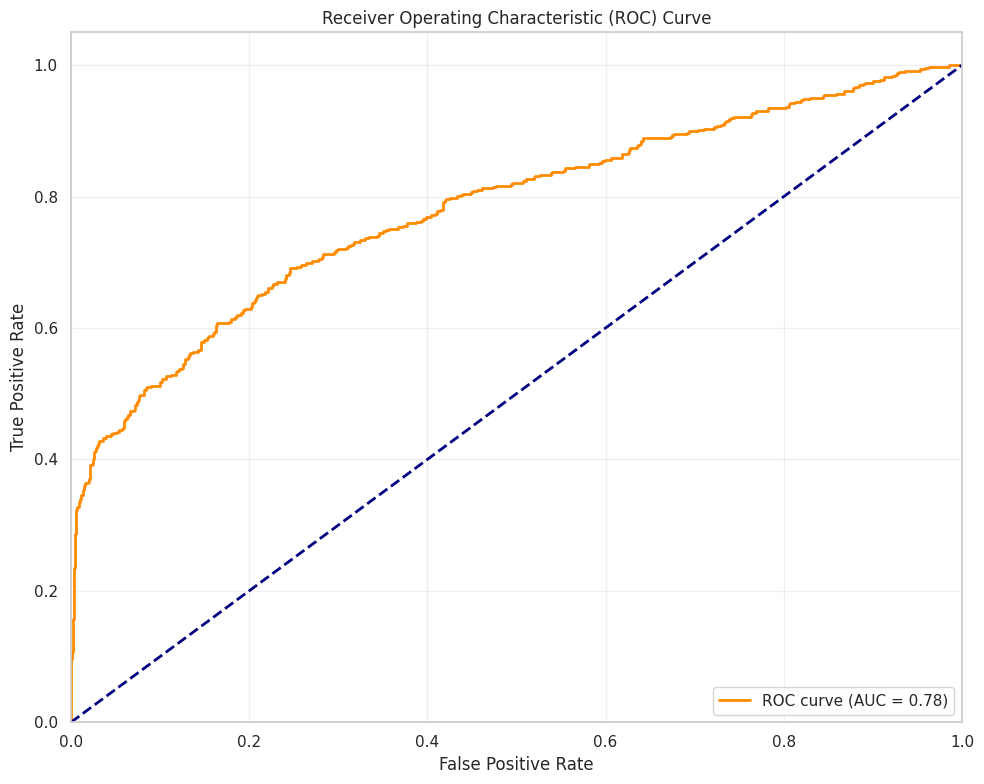

In [12]:
## Test Set Evaluation
import seaborn as sns
import matplotlib.pyplot as plt
print("Evaluating model on test set...")
model.eval()  # Set the model to evaluation mode

# Initialize metrics
test_loss = 0.0
total = 0
correct = 0
test_labels = []
test_predictions = []
test_raw_predictions = []  # For storing raw probabilities

with torch.no_grad():
    for data in test_loader:
        inputs_cc, inputs_mlo, labels = data
        inputs_cc = inputs_cc.float().to(device)
        inputs_mlo = inputs_mlo.float().to(device)
        labels = labels.float().to(device)
        
        labels = labels.unsqueeze(1)
        predicted = model(inputs_cc, inputs_mlo)
        
        # Calculate loss
        loss = criterion(predicted, labels)
        test_loss += loss.item()
        
        # Apply threshold
        thresholded_preds = (predicted > threshold).float()
        
        # Update metrics
        total += labels.size(0)
        correct += (thresholded_preds == labels).sum().item()
        
        # Store predictions and labels for metrics computation
        test_labels.extend(labels.cpu().numpy())
        test_predictions.extend(thresholded_preds.cpu().numpy())
        test_raw_predictions.extend(predicted.cpu().numpy())

# Calculate metrics
test_loss = test_loss / len(test_loader)
test_acc = 100 * correct / total
test_precision = precision_score(test_labels, test_predictions)
test_recall = recall_score(test_labels, test_predictions)
test_f1 = f1_score(test_labels, test_predictions)

# Print results
print("\nTest Set Metrics:")
print(f"  Loss: {test_loss:.5f}")
print(f"  Accuracy: {test_acc:.3f}%")
print(f"  Precision: {test_precision:.3f}")
print(f"  Recall: {test_recall:.3f}")
print(f"  F1 Score: {test_f1:.3f}")

# Calculate confusion matrix
from sklearn.metrics import confusion_matrix

# Create and plot confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(10, 8))
sns.set_theme(style="whitegrid")  # Set seaborn theme
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix on Test Set', pad=20)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# ROC curve and AUC score
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(test_labels, test_raw_predictions)
roc_auc = auc(fpr, tpr)

# Set style for ROC curve
plt.figure(figsize=(10, 8))
sns.set_theme(style="whitegrid")  # Reset style for new plot
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Model Evaluation on Test Set
After training, let's evaluate the model's performance on the test set to get unbiased metrics.